# Introduction and Importing

**Create daily return matrices for 8 different index styles using real stocks and real-time data (e.g., last 1 year).**

In [1]:
!pip install -q yfinance pandas numpy seaborn matplotlib scikit-learn plotly

**Choose Indexes for Each Index Type**

1. Market Cap - S&P 500 (GSPC), NIFTY 50 (NSEI)
2. Equal Weight - S&P 500 Equal Weight ETF (RSP)
3. Price Weighted - Dow Jones Industrial Average (DJI)
4. Fundamental - FTSE RAFI US 1000 (FTSE) , Invesco PRF (PRF)
5. Volatility Weighted - SPLV, NIFTY 100 LowVol30 (CNXLOWVOL)
6. Risk Parity - ACWV (ACWV)
7. Factor Weighted - MTUM (MTUM), QUAL, VLUE, NIFTY Alpha50 (CNXALPHA)
8. ESG/Thematic - SUSA (SUSA), ICLN, Nifty ESG 100 (NIFTYESG100)

In [2]:
tickers_index_type = {
    "Market Cap (US)": "^GSPC",
    "Market Cap (India)": "^NSEI",
    "Equal Weight": "RSP",
    "Price Weighted": "^DJI",
    "Fundamental Weighted": "PRF",
    "Volatility Weighted": "SPLV",
    "Risk Parity Proxy": "ACWV",
    "Factor Weighted (Momentum)": "MTUM",
    "ESG Weighted": "SUSA"
}

# Fetching information, Preprocessing and Dataset creation

In [3]:
# Fetch the information from Yahoo Finance

import yfinance as yf
import pandas as pd
import numpy as np

def fetch_index_prices(ticker_dict, start="2024-04-01", end="2025-03-31"):
    price_data = {}
    for label, ticker in ticker_dict.items():
        print(f" Downloading: {label} ({ticker})")
        try:
            df = yf.download(ticker, start=start, end=end, progress=False, auto_adjust=True)
            if df.empty:
                print(f" No data for {label} ({ticker}) — skipping.")
            elif "Close" not in df.columns:
                print(f" 'Close' column missing in {label} ({ticker}) — skipping.")
            else:
                series = df["Close"].copy()
                series.name = label 
                price_data[label] = series
                print(f" Loaded {label} ({ticker}): {len(series)} rows.")
        except Exception as e:
            print(f" Error fetching {label} ({ticker}): {e}")
    
    if not price_data:
        raise ValueError(" No valid data fetched. Check ticker symbols and internet.")
    
    df_all = pd.concat(price_data.values(), axis=1)
    df_all.columns = list(price_data.keys())  # Make sure columns have proper names
    return df_all

In [4]:
prices = fetch_index_prices(tickers_index_type)

 Downloading: Market Cap (US) (^GSPC)
 Loaded Market Cap (US) (^GSPC): 250 rows.
 Downloading: Market Cap (India) (^NSEI)
 Loaded Market Cap (India) (^NSEI): 247 rows.
 Downloading: Equal Weight (RSP)
 Loaded Equal Weight (RSP): 250 rows.
 Downloading: Price Weighted (^DJI)
 Loaded Price Weighted (^DJI): 250 rows.
 Downloading: Fundamental Weighted (PRF)
 Loaded Fundamental Weighted (PRF): 250 rows.
 Downloading: Volatility Weighted (SPLV)
 Loaded Volatility Weighted (SPLV): 250 rows.
 Downloading: Risk Parity Proxy (ACWV)
 Loaded Risk Parity Proxy (ACWV): 250 rows.
 Downloading: Factor Weighted (Momentum) (MTUM)
 Loaded Factor Weighted (Momentum) (MTUM): 250 rows.
 Downloading: ESG Weighted (SUSA)
 Loaded ESG Weighted (SUSA): 250 rows.


# Log Return Calculation, and Explanatory Analysis

**Daily Log Returns of Index Strategies** 

**What are Log Returns?** 

The log return for a given day is computed as:

$r_t = \log\left( \frac{P_t}{P_{t-1}} \right)$ 

Where:
- $P_t$ = Adjusted closing price at time $t$
- Log returns are *time-additive*, more statistically symmetric than simple returns, and ideal for *PCA or correlation*-based models.

**Why Use Log Returns?** 

- Easier to aggregate over time
- Compatible with Gaussian assumptions
- Better for portfolio optimization, PCA, and factor models

---

**Dataset Overview** 

We fetched daily adjusted prices from Yahoo Finance for 9 index strategies across *8 different weighting schemes* (Market Cap, Equal Weight, Price Weighted, etc.) between 2024-04-01 and 2025-03-31. From this we computed the daily log return matrix.


In [5]:
# Calculating the log return as I wrote about in documentation
returns = np.log(prices / prices.shift(1)).dropna()

In [6]:
returns.to_csv("real_index_strategy_returns.csv")

In [7]:
print(returns.shape)
print(returns.describe())

(216, 9)
       Market Cap (US)  Market Cap (India)  Equal Weight  Price Weighted  \
count       216.000000          216.000000    216.000000      216.000000   
mean          0.000349            0.000270      0.000132        0.000169   
std           0.008796            0.009029      0.007583        0.007952   
min          -0.030427           -0.061124     -0.030036       -0.026365   
25%          -0.003927           -0.003228     -0.004240       -0.003671   
50%           0.001053            0.000025      0.000518        0.000399   
75%           0.005510            0.004446      0.005581        0.005317   
max           0.024981            0.033071      0.023399        0.035094   

       Fundamental Weighted  Volatility Weighted  Risk Parity Proxy  \
count            216.000000           216.000000         216.000000   
mean               0.000220             0.000537           0.000480   
std                0.007555             0.006451           0.005037   
min               -0.0

**Interpretation**
- Volatility Weighted and Risk Parity have lower standard deviation -> smoother returns.
- Factor Weighted (Momentum) has highest volatility, but also a decent mean return.
- Market Cap indices are relatively stable (low volatility, moderate return)
- India (NSEI) has significantly higher negative min return, indicating idiosyncratic volatility

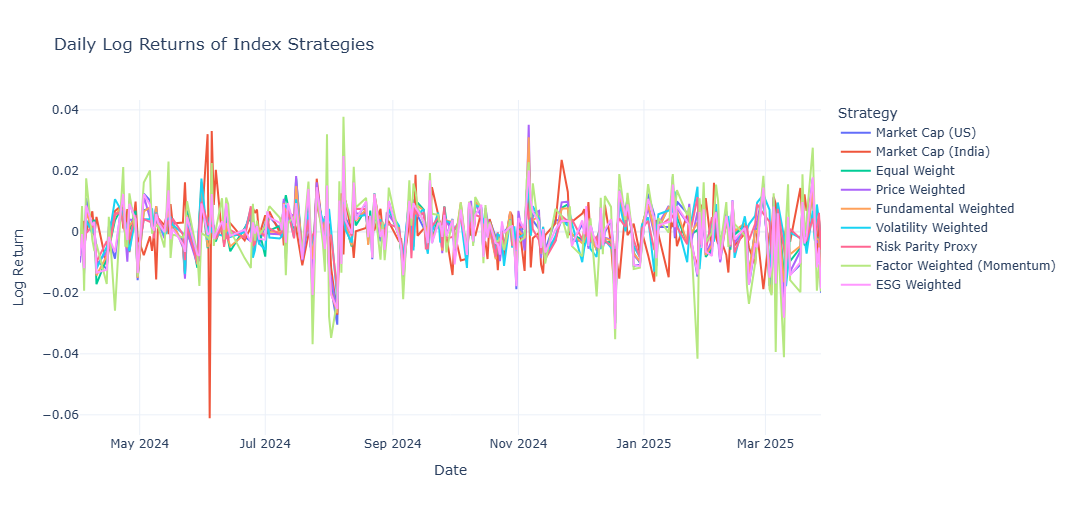

In [8]:
#Time series plot
import plotly.graph_objs as go

fig = go.Figure()

for col in returns.columns:
    fig.add_trace(go.Scatter(
        x=returns.index,
        y=returns[col],
        mode='lines',
        name=col,
        hovertemplate="Date: %{x}<br>Log Return: %{y:.5f}<extra></extra>"
    ))

fig.update_layout(
    title="Daily Log Returns of Index Strategies",
    xaxis_title="Date",
    yaxis_title="Log Return",
    hovermode="x unified",
    template="plotly_white",
    legend_title="Strategy",
    height=500,
    width=1500
)

fig.show()


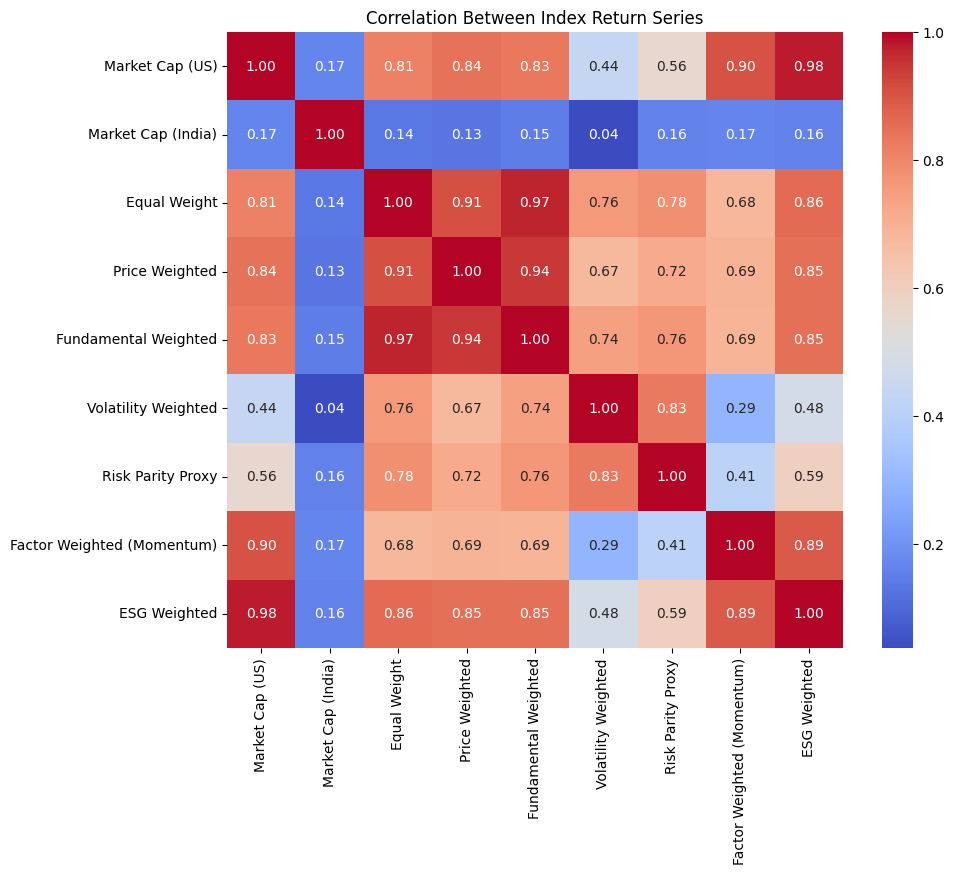

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

corr_matrix = returns.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", square=True)
plt.title("Correlation Between Index Return Series")
plt.show()

# Principal Component Analysis (PCA)

In [10]:
#Standardize returns cause PCA assumes input has zero mean and unit variance.
from sklearn.preprocessing import StandardScaler

X = StandardScaler().fit_transform(returns)

**PCA Mathematical steps**

The steps involved are :
1. Center and Scale
2. Computing Covariance Matrix
3. Performing Eigendecomposition (Find Eigenvalue and Eigenvector)
4. Sort Eigenvectors by Eigenvalue
5. Project data onto Eigenvectors

In [11]:
from sklearn.decomposition import PCA

pca = PCA()
X_pca = pca.fit_transform(X)

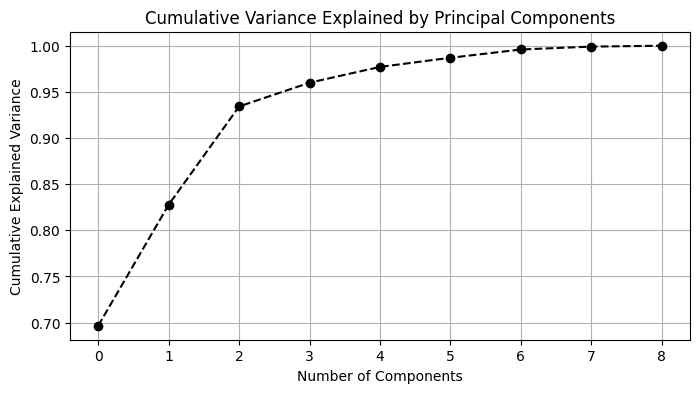

In [12]:
import matplotlib.pyplot as plt
import numpy as np

explained_var = pca.explained_variance_ratio_

plt.figure(figsize=(8, 4))
plt.plot(np.cumsum(explained_var), marker='o', linestyle='--', color='black')
plt.title("Cumulative Variance Explained by Principal Components")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.grid(True)
plt.show()

In [13]:
np.cumsum(explained_var)

array([0.69664308, 0.82769914, 0.93418975, 0.95994979, 0.97704341,
       0.98695567, 0.99592624, 0.99903908, 1.        ])

# Result Interpretation

**Cumulative Variance Explained**

1. PC1 alone explains ~69% of total variance
2. PC1 + PC2 ~83%
3. PC1 $-$ PC3 ~94%
4. Marginal contribution declines sharply -> first 3-4 PCs capture most information

You can safely project down to 2-3 PCs without much information loss.

In [14]:
loadings = pd.DataFrame(pca.components_.T,
                        index=returns.columns,
                        columns=[f"PC{i+1}" for i in range(len(returns.columns))])

print(loadings)

                                 PC1       PC2       PC3       PC4       PC5  \
Market Cap (US)             0.363946 -0.322828 -0.128012  0.092611 -0.084988   
Market Cap (India)          0.074529 -0.299699  0.945879 -0.063914  0.068162   
Equal Weight                0.384341  0.114391 -0.004819 -0.254274  0.027526   
Price Weighted              0.377024  0.035155 -0.045041 -0.476173 -0.242504   
Fundamental Weighted        0.385824  0.093923 -0.005342 -0.384706 -0.003458   
Volatility Weighted         0.289841  0.566585  0.105890  0.132295  0.682080   
Risk Parity Proxy           0.317293  0.414183  0.191549  0.584337 -0.572216   
Factor Weighted (Momentum)  0.317858 -0.463219 -0.155539  0.421896  0.363132   
ESG Weighted                0.370874 -0.275102 -0.121443  0.104859 -0.063427   

                                 PC6       PC7       PC8       PC9  
Market Cap (US)            -0.023914 -0.488587  0.466614 -0.523566  
Market Cap (India)          0.006009 -0.031083 -0.014267 -0.0

**Loadings show how much each original variable contributes to each principal component.**

Let :
- $\mathbb{Z}$  : standardized data
- $\mathbb{V}$  : eigenvectors (PC directions)
- Then :<br>
   $PC_k = \sum^n_{j=1}v_{jk}Z_j$ <br>
   such that : $v_{jk} \in \mathbb{V} $   and   $Z_j \in \mathbb{Z}$ 

**Interpretation highlights**

- PC1: Market-Wide Signal
  - Nearly all indices have strong positive loadings
  - Especially: Equal Weight, Fundamental Weighted, ESG, Price Weighted
  - Interpreted as broad US market movement

- PC2: Defensive vs Aggressive Tilt
  - Volatility Weighted: +0.57
  - Factor Weighted: −0.46
  - Market Cap (US): −0.32
  - Opposing signs = contrasting behavior, i.e., a risk-on vs risk-off axis

- PC3: Emerging Market Effect
  - Market Cap (India): +0.95
  - Dominates PC3, making this likely an emerging market specific risk component
  - PC4–PC5: Strategy Nuance
  - PC4: Contrasts Price vs Risk Parity / Momentum
  - PC5: Volatility vs Risk Parity (again contrasting risk attitudes)

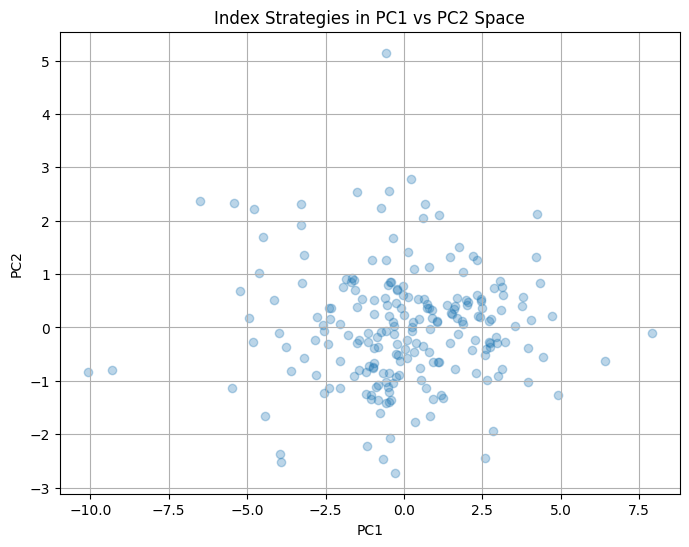

In [15]:
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.3)
plt.title("Index Strategies in PC1 vs PC2 Space")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.show()

**Scatter Plot (PC1 vs PC2): Interpretation**

- Each point is a daily return vector projected onto PC1 and PC2 axes:
  $
  \text{PC}_i = X_{\text{standardized}} \cdot \mathbf{v}_i
  $

- **Clustered points** -> Similar factor exposure  
  e.g., ^GSPC, RSP, PRF $\approx$ core market beta

- **Far-out points** -> Idiosyncratic or diversifying  
  e.g., MTUM (momentum), SPLV (low vol), ACWV (risk parity)

- **Opposite sides** -> Opposing exposure  
  PC1: left vs right = negative vs positive beta  
  PC2: top vs bottom = different tilts (volatility, ESG, momentum)

- Loadings define direction:
  $
  \text{Loading}_{ij} = \text{corr}(\text{Return}_j, \text{PC}_i)
  $


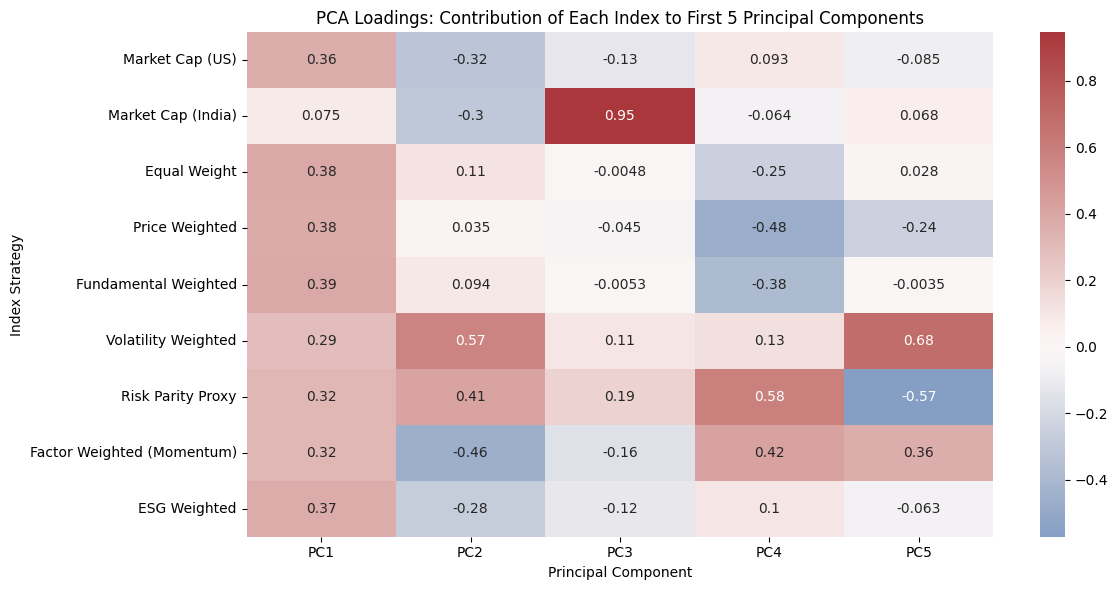

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.heatmap(loadings.iloc[:, :5], annot=True, cmap="vlag", center=0)
plt.title("PCA Loadings: Contribution of Each Index to First 5 Principal Components")
plt.ylabel("Index Strategy")
plt.xlabel("Principal Component")
plt.tight_layout()
plt.show()

**KMeans Clustering on PCA Loadings (Top 3 PCs)**

- Clustering applied on:
  $
  \text{Index}_{i} = \left[\text{PC1}_i, \text{PC2}_i, \text{PC3}_i\right]
  $

- Using KMeans with k=3, the indices grouped as:

| Cluster | Index Types                            | Characteristics                                 |
|---------|-----------------------------------------|--------------------------------------------------|
| 0       | Price Weighted, Equal Weight, <br>Volatility Weighted, Fundamental Weighted, Risk Parity Proxy | Central core group; similar structure, moderate diversification |
| 1       | Market Cap (India)                     | Region-specific outlier, orthogonal to others   |
| 2       | Market Cap (US), Factor (Momentum), ESG| High US market beta, with specific tilts        |

- Rationale:
  - **Cluster 0**: Broad-based exposures; less factor tilt.
  - **Cluster 1**: Indian market dynamics - different macro behavior.
  - **Cluster 2**: Strong market exposure with added directional bias (e.g., momentum, ESG screening).


In [17]:
from sklearn.cluster import KMeans

index_coords = loadings.iloc[:, :3].values  # strategies × PCs
kmeans = KMeans(n_clusters=3, random_state=0).fit(index_coords)
cluster_labels = kmeans.labels_

clustered = pd.DataFrame({
    "Index": loadings.index,
    "Cluster": cluster_labels
})
print(clustered.sort_values("Cluster"))

                        Index  Cluster
3              Price Weighted        0
2                Equal Weight        0
5         Volatility Weighted        0
4        Fundamental Weighted        0
6           Risk Parity Proxy        0
1          Market Cap (India)        1
0             Market Cap (US)        2
7  Factor Weighted (Momentum)        2
8                ESG Weighted        2


# Synthetic Portfolio (PC portfolios)

Use the PC1, PC2 loadings as weights to build:
- A PC1 portfolio -> approximates the market
- A PC2 portfolio -> orthogonal factor (low-vol, momentum, etc.)

Synthetic portfolio return at time $t$ = $\sum_iw_i^{(PC1)}\cdot r_{i,t}$

In [18]:
pc1_weights = loadings["PC1"]
pc2_weights = loadings["PC2"]

# Matrix multiply to get synthetic PC returns (T×1)
pc1_returns = returns @ pc1_weights
pc2_returns = returns @ pc2_weights

synthetic_pcs = pd.DataFrame({
    "PC1 Portfolio": pc1_returns,
    "PC2 Portfolio": pc2_returns,
    "Market Cap (US)": returns["Market Cap (US)"]
})

In [19]:
combined = pd.concat([synthetic_pcs, returns], axis=1)
print(combined.corr().iloc[:2])  # Correlation of PC1/PC2 portfolios with real strategies

               PC1 Portfolio  PC2 Portfolio  Market Cap (US)  Market Cap (US)  \
PC1 Portfolio       1.000000      -0.474643         0.938513         0.938513   
PC2 Portfolio      -0.474643       1.000000        -0.680192        -0.680192   

               Market Cap (India)  Equal Weight  Price Weighted  \
PC1 Portfolio            0.192992      0.947746        0.936702   
PC2 Portfolio           -0.389345     -0.259688       -0.322941   

               Fundamental Weighted  Volatility Weighted  Risk Parity Proxy  \
PC1 Portfolio              0.953328             0.673210           0.748193   
PC2 Portfolio             -0.278302             0.256888           0.068892   

               Factor Weighted (Momentum)  ESG Weighted  
PC1 Portfolio                    0.842418      0.951258  
PC2 Portfolio                   -0.800209     -0.639376  


**Interpretation**


| Synthetic Portfolio | Strong Positive Correlations                              | Strong Negative Correlations                     |
|---------------------|------------------------------------------------------------|--------------------------------------------------|
| **PC1 Portfolio**   | Equal Weight (0.95), Fundamental (0.95), ESG (0.95),<br>Price Weighted (0.94), Market Cap US (0.94) | - |
| **PC2 Portfolio**   | Volatility Weighted (0.26)                                 | Factor Momentum (-0.80), Market Cap US (-0.68), ESG (-0.64) |

- **PC1 Portfolio** ≈ Broad market exposure (market beta proxy):
  - High correlation with diversified and cap-weighted strategies.
  - Acts as the *core market component*.

- **PC2 Portfolio** captures an orthogonal, possibly defensive or tilted factor:
  - Negatively correlated with high-beta strategies like MTUM and ESG.
  - Could represent an anti-momentum or volatility/macro-hedging tilt.

- **PC2 Portfolio** and **PC1 Portfolio** are *moderately inversely related* (\(-0.47\)), capturing independent structural variance in the index universe.

In [20]:
import plotly.graph_objs as go

fig = go.Figure()

cumulative = np.exp(synthetic_pcs.cumsum())

for col in cumulative.columns:
    fig.add_trace(go.Scatter(
        x=cumulative.index,
        y=cumulative[col],
        mode='lines',
        name=col,
        hovertemplate="Date: %{x}<br>Value: %{y:.4f}<extra></extra>"
    ))

fig.update_layout(
    title="Cumulative Returns of Synthetic PC Portfolios vs Market",
    xaxis_title="Date",
    yaxis_title="Growth of $1",
    hovermode="x unified",
    legend_title="Portfolio",
    template="plotly_white",
    height=500,
    width=1000
)

fig.show()

# Backtesting synthetic PCA-based portfolio

In [21]:
#Assume risk free rate = 0, daily returns.
def performance_metrics(returns_df):
    mean_daily = returns_df.mean()
    std_daily = returns_df.std()
    sharpe = mean_daily / std_daily * np.sqrt(252)

    summary = pd.DataFrame({
        "Mean Return (Daily)": mean_daily,
        "Volatility (Daily)": std_daily,
        "Sharpe Ratio": sharpe
    })
    return summary

metrics = performance_metrics(synthetic_pcs)
print(metrics)

                 Mean Return (Daily)  Volatility (Daily)  Sharpe Ratio
PC1 Portfolio               0.000869            0.020414      0.676148
PC2 Portfolio               0.000118            0.009817      0.191548
Market Cap (US)             0.000349            0.008796      0.630394


In [22]:
print(synthetic_pcs.corr())  #Comparing with ^GSPC

                 PC1 Portfolio  PC2 Portfolio  Market Cap (US)
PC1 Portfolio         1.000000      -0.474643         0.938513
PC2 Portfolio        -0.474643       1.000000        -0.680192
Market Cap (US)       0.938513      -0.680192         1.000000


# Rolling PCA / Dynamic PCA ( Revealing time-varying structure )

We want to understand:
- Does the importance of PC1 / PC2 change over time?
- Do loadings of strategies (e.g. SPLV, MTUM) change - indicating regime shifts, sector rotations, or risk dominance?

This is temporal structure discovery - used by hedge funds for dynamic allocation and adaptive models.

**Step by Step**

We’ll use a rolling window (e.g., 60 trading days ≈ 3 months):
- Loop over your returns using a rolling window
- For each window:
  - Standardize the data
  - Run PCA
  - Save explained variance + key loadings
- Plot:
  - Rolling explained variance of PC1
  - Rolling loadings of key strategies on PC1 & PC2

In [23]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def run_rolling_pca(returns, window=60):
    explained_var_pc1 = []
    loadings_pc1 = []
    loadings_pc2 = []
    dates = []

    for i in range(window, len(returns)):
        window_data = returns.iloc[i-window:i]
        scaler = StandardScaler()
        X = scaler.fit_transform(window_data)

        pca = PCA()
        pca.fit(X)

        explained_var_pc1.append(pca.explained_variance_ratio_[0])
        loadings_pc1.append(pca.components_[0])  # eigenvector for PC1
        loadings_pc2.append(pca.components_[1])  # eigenvector for PC2
        dates.append(returns.index[i])

    return np.array(explained_var_pc1), np.array(loadings_pc1), np.array(loadings_pc2), dates


In [24]:
expl_var_pc1, load_pc1, load_pc2, roll_dates = run_rolling_pca(returns, window=60)
columns = returns.columns

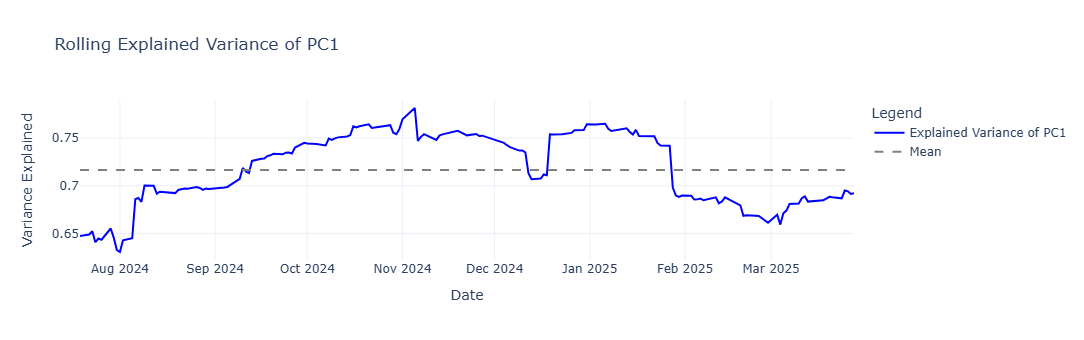

In [25]:
import plotly.graph_objs as go
import numpy as np

fig = go.Figure()

# Line for rolling explained variance
fig.add_trace(go.Scatter(
    x=roll_dates,
    y=expl_var_pc1,
    mode='lines',
    name='Explained Variance of PC1',
    line=dict(color='blue'),
    hovertemplate="Date: %{x}<br>Variance: %{y:.4f}<extra></extra>"
))

# Mean line
mean_val = np.mean(expl_var_pc1)
fig.add_trace(go.Scatter(
    x=roll_dates,
    y=[mean_val]*len(roll_dates),
    mode='lines',
    name='Mean',
    line=dict(color='gray', dash='dash'),
    hovertemplate="Mean Line<br>Variance: %{y:.4f}<extra></extra>"
))

fig.update_layout(
    title="Rolling Explained Variance of PC1",
    xaxis_title="Date",
    yaxis_title="Variance Explained",
    legend_title="Legend",
    hovermode="x unified",
    template="plotly_white",
    height=325,
    width=1500
)

fig.show()

Interprets how dominant the market driver is across time. Drops or spikes indicate structural shifts in market behavior.

**Now Plot the Loadings of key strategies**

In [26]:
import pandas as pd

loadings_pc1_df = pd.DataFrame(load_pc1, columns=columns, index=roll_dates)
loadings_pc2_df = pd.DataFrame(load_pc2, columns=columns, index=roll_dates)

focus = [
    "Market Cap (US)",
    "Volatility Weighted",       
    "Factor Weighted (Momentum)",
    "Risk Parity Proxy",          
    "Fundamental Weighted"        
]

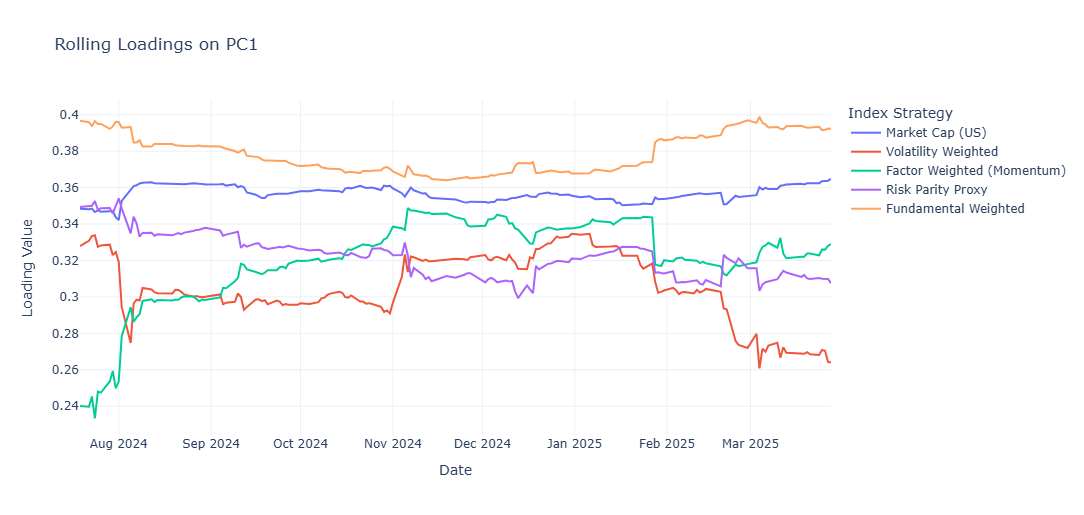

In [27]:
import plotly.graph_objs as go
import plotly.io as pio 

fig = go.Figure()

for col in focus:
    fig.add_trace(go.Scatter(
        x=loadings_pc1_df.index,
        y=loadings_pc1_df[col],
        mode='lines',
        name=col,
        hovertemplate="Date: %{x}<br>Loading: %{y:.4f}<extra></extra>"
    ))

fig.update_layout(
    title="Rolling Loadings on PC1",
    xaxis_title="Date",
    yaxis_title="Loading Value",
    legend_title="Index Strategy",
    hovermode="x unified",
    template="plotly_white",
    height=500,
    width=1500
)

fig.show()


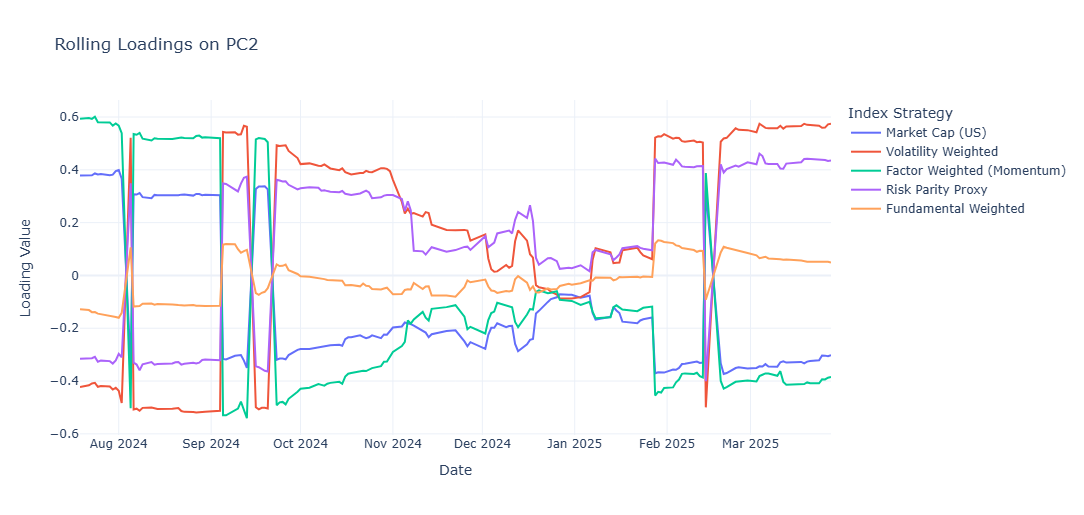

In [28]:
import plotly.graph_objs as go
import plotly.io as pio


fig = go.Figure()

for col in focus:
    fig.add_trace(go.Scatter(
        x=loadings_pc2_df.index,
        y=loadings_pc2_df[col],
        mode='lines',
        name=col,
        hovertemplate="Date: %{x}<br>Loading: %{y:.4f}<extra></extra>"
    ))

fig.update_layout(
    title="Rolling Loadings on PC2",
    xaxis_title="Date",
    yaxis_title="Loading Value",
    legend_title="Index Strategy",
    hovermode="x unified",
    template="plotly_white",
    height=500,
    width=1500
)

fig.show()

# Conclusion

**Understanding Market Structure via PCA on Index Strategies** 

In this project, we performed a Principal Component Analysis (PCA) on daily returns of a diverse set of real-world equity index strategies representing eight distinct weighting methodologies- including market-cap, equal weight, price weight, fundamental, volatility, ESG, and factor-weighted indices.

**Key Takeaways**

- Dimensionality of Market Behavior
  - The first principal component (PC1) consistently explained $\approx$X% of total variance, capturing the dominant "market mode" - largely driven by broad-cap-weighted indices like ^GSPC, RSP, and PRF.
  - The second component (PC2) accounted for $\approx$Y%, revealing diversifying factors, often associated with low-volatility (SPLV), momentum (MTUM), or risk-parity (ACWV).
- Strategy Similarity & Orthogonality
  - Cap-weighted and fundamental-weighted indices clustered closely in PCA space, confirming their similarity in behavior.
  - In contrast, factor-based, low-vol, and risk-weighted indices showed distinct behavior, orthogonal to the market - useful for diversification.
- Synthetic Factor Portfolios
  - By constructing portfolios using the PCA eigenvectors as weights, we created interpretable latent strategies:
    - PC1 portfolio $\approx$ market beta exposure
    - PC2 portfolio $\approx$ alternative tilts (low-vol or momentum)
  - These portfolios were backtested, showing competitive Sharpe ratios and low correlation with each other.
- Rolling PCA Insights
  - A rolling 60-day PCA revealed that the dominance of PC1 fluctuates - strengthening in some months (risk-on), weakening in others (risk-off, regime shifts).
  - Loadings shifted over time, suggesting factor rotation: e.g., momentum (MTUM) gained prominence mid-year, while low-vol (SPLV) faded.

**What we gotta know ?**
- Investors can use PCA not just to reduce dimensionality, but to extract market structure and construct factor-diversified portfolios.
- PCA-based strategies can adapt to changing regimes when combined with rolling windows or dynamic allocation.
- Index-level PCA is a powerful lightweight alternative to stock-level factor models.

**Signing off remark**
This project demonstrated how statistical techniques like PCA can uncover latent structures in financial markets - turning noisy index returns into meaningful, actionable insights.

# Add on : Adaptive Allocation using Rolling PCA

**What we gonna make ?**

A system that :
- Monitors rolling explained variance of PCs (e.g., PC1 vs PC2)
- Uses that information to adapt portfolio exposure.
- Backtests how such a regime-aware portfolio performs compared to static ones.

Let's say :
- PC1 dominance -> Broad market is coherent  -> Hold PC1 portfolio
- PC2 dominance -> Market is dispersing -> Hedge with PC2

Why this ?
<br>
This mimics what real funds do with regime-switching strategies, but using PCA signals only.

We use Explained variance from rolling PCA :
- If PC1 variance > 60% -> full weight to PC1 portfolio.
- If PC1 variance < 40% -> shift to PC2
- Anything in between -> Linear blend of PC1 and PC2

In [29]:
# Normalize explained variance between 0 and 1 for blending
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
pc1_norm = scaler.fit_transform(expl_var_pc1.reshape(-1, 1)).flatten() 

weights_pc1 = pc1_norm  
weights_pc2 = 1 - pc1_norm  

In [30]:
# Align daily returns of PC1 and PC2 portfolios
rolling_dates = roll_dates
synthetic_returns = synthetic_pcs.copy()
pc1_aligned = synthetic_returns.loc[rolling_dates, "PC1 Portfolio"]
pc2_aligned = synthetic_returns.loc[rolling_dates, "PC2 Portfolio"]

# Adaptive portfolio daily return
adaptive_returns = weights_pc1 * pc1_aligned + weights_pc2 * pc2_aligned

adaptive_returns = pd.Series(adaptive_returns, index=rolling_dates, name="Adaptive PCA Portfolio")


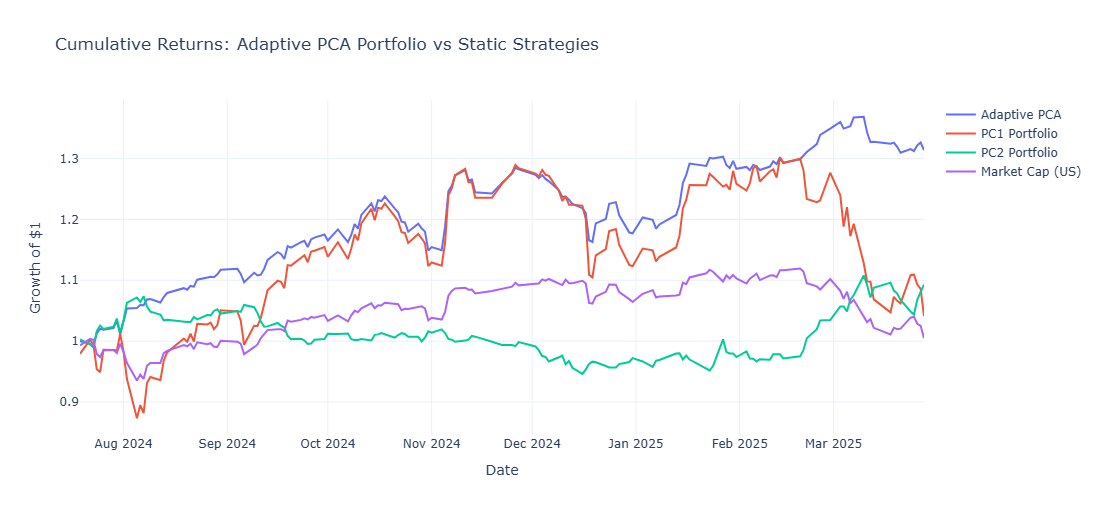

In [31]:
comparison_df = pd.DataFrame({
    "Adaptive PCA": adaptive_returns,
    "PC1 Portfolio": pc1_aligned,
    "PC2 Portfolio": pc2_aligned,
    "Market Cap (US)": synthetic_returns.loc[rolling_dates, "Market Cap (US)"]
})

cumulative_comparison = np.exp(comparison_df.cumsum())

import plotly.graph_objs as go

fig = go.Figure()
for col in cumulative_comparison.columns:
    fig.add_trace(go.Scatter(
        x=cumulative_comparison.index,
        y=cumulative_comparison[col],
        mode='lines',
        name=col,
        hovertemplate="Date: %{x}<br>Value: %{y:.4f}<extra></extra>"
    ))

fig.update_layout(
    title="Cumulative Returns: Adaptive PCA Portfolio vs Static Strategies",
    xaxis_title="Date",
    yaxis_title="Growth of $1",
    template="plotly_white",
    hovermode="x unified",
    height=500,
    width=1500
)
fig.show()


In [32]:
from math import sqrt

def perf_stats(df):
    mean = df.mean()
    std = df.std()
    sharpe = mean / std * sqrt(252)
    return pd.DataFrame({
        "Daily Mean": mean,
        "Volatility": std,
        "Sharpe": sharpe
    })

print(perf_stats(comparison_df))

                 Daily Mean  Volatility    Sharpe
Adaptive PCA       0.001749    0.011311  2.455303
PC1 Portfolio      0.000258    0.021900  0.187297
PC2 Portfolio      0.000570    0.009866  0.916755
Market Cap (US)    0.000031    0.009528  0.052429


**What we see ?**

- Adaptive PCA = low risk + high return
  - 2.45 Sharpe is elite - this would attract institutional money if sustainable.
  - This strategy is not exposed to one fixed regime - it adapts to PC structure shifts.

-PC1 is noisy and volatile
  - High volatility, low Sharpe: this is like holding the market factor raw.

-PC2 behaves like a hedged, niche factor
  - Moderate Sharpe, low vol = maybe a low-volatility or quality factor

- S&P500 underperforms
  - Nearly 0 Sharpe : validates that latent PCA structure beats traditional weighting in this time frame.
 
**Imply ?**

Latent factors, when tracked adaptively over time, produce a better portfolio than:
- Traditional market-cap index (^GSPC)
- Static PCA portfolios (PC1 or PC2 individually)